### While visiting Scottsdale, are visitors from some states more likely to be arrested than visitors from other states?

#### Data for people arrested accessed from the City of Scottsdale Data Portal [here](http://data.scottsdaleaz.gov/dataset/police-departmental-arrest-data).  

#### Data for visitors to Scottsdale from out of state accessed on the City of Scottsdale website [here](https://www.scottsdaleaz.gov/Assets/ScottsdaleAZ/Tourism+Reports/2018+Visitor+Report+Longwoods.pdf) (p.32).

In [1]:
import numpy as np
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

#SQL Query pulls into Scottsdale arrestees with AZ arrestees already excluded 
ArresteesbyState = '''
 select  
	SUBSTRING(
		[City of Arrestee]
		,charindex(',',[City of Arrestee]) +2
		,2
	) as State_of_Arrestee
	,count(*) as _Count_
from [dbo].[spd_PDArrests$]
where [City of Arrestee] not like '%, AZ %' and --AZ arrestees excluded
	[City of Arrestee] like '%, __ _____' --messy, non-standard records excluded
group by SUBSTRING(
		[City of Arrestee]
		,charindex(',',[City of Arrestee]) +2
		,2
	)
    '''
# save the sql query to a pandas dataframe
ArresteesbyState = pd.read_sql(ArresteesbyState, connection)
connection.close()

#Create column 'Percent'
ArresteesbyState['Percent'] = ArresteesbyState._Count_.apply(lambda x: x/ArresteesbyState._Count_.sum()*100)

#format with more decimal places
pd.options.display.float_format = '{:,.4f}'.format

ArresteesbyState['Percent'] = ArresteesbyState.Percent.astype(float)

ArresteesbyState.sort_values(['_Count_'],ascending=False, inplace=True) #sort dataset

# rename state column to be able to do join below
ArresteesbyState = ArresteesbyState.rename({'State_of_Arrestee': 'State'}, axis= 'columns')

# rename Percent column to make join below more clear
ArresteesbyState = ArresteesbyState.rename({'Percent': 'Percent_Arrested'}, axis= 'columns')

In [2]:
ArresteesbyState.head(10)

,State,_Count_,Percent_Arrested
5,CA,88,36.5145
11,IL,17,7.0539
33,TX,14,5.8091
36,WA,14,5.8091
24,NV,9,3.7344
30,PA,7,2.9046
6,CO,7,2.9046
7,FL,7,2.9046
25,NY,6,2.4896
23,NM,6,2.4896


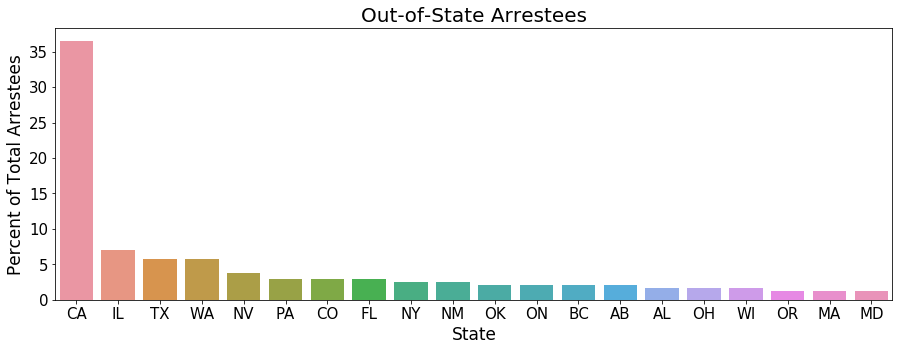

In [3]:
plt.rcParams["figure.figsize"] = [15, 5]

ax = sns.barplot(x=ArresteesbyState.iloc[:,0].head(20), y=ArresteesbyState.iloc[:,2].head(20))
plt.title('Out-of-State Arrestees',fontsize=20)
plt.ylabel('Percent of Total Arrestees',fontsize=17)
plt.xlabel('State',fontsize=17)
plt.tick_params(labelsize=15)

### How do the above percentages compare with the percent of visitors from each state?  

### Note: The report on percentages of visitors from each state only included the top 10 states.  Since I was only interested in out of state visitors I excluded Arizona, resulting in only 9 states.

In [5]:
longwoods_data = pd.DataFrame({'State':['CA','CO','IL','NY','TX','NV','NJ','WI','NM'],
                  'Percent':['17','8','7','4','4','4','3','3','3']})

longwoods_data['Percent'] = pd.to_numeric(longwoods_data['Percent'])

#compute out of state percent for each state(percent provided by Longwoods report included AZ arrestees) 
longwoods_data['Percent_Of_Visitors'] = (longwoods_data['Percent']/longwoods_data['Percent'].sum())*100
longwoods_data

,State,Percent,Percent_Of_Visitors
0,CA,17,32.0755
1,CO,8,15.0943
2,IL,7,13.2075
3,NY,4,7.5472
4,TX,4,7.5472
5,NV,4,7.5472
6,NJ,3,5.6604
7,WI,3,5.6604
8,NM,3,5.6604


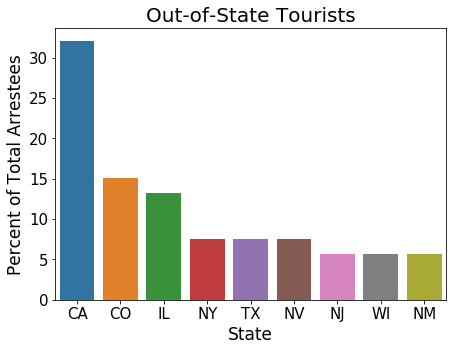

In [6]:
plt.rcParams["figure.figsize"] = [7, 5]

ax = sns.barplot(x=longwoods_data.iloc[:,0], y=longwoods_data.iloc[:,2])

plt.title('Out-of-State Tourists',fontsize=20)
plt.ylabel('Percent of Total Arrestees',fontsize=17)
plt.xlabel('State',fontsize=17)
plt.tick_params(labelsize=15)

In [7]:
# join datasets of visitors and arrestees
arrestees_and_visitors = pd.merge(ArresteesbyState.head(25),longwoods_data, on='State',how='left')
arrestees_and_visitors.head(10)

,State,_Count_,Percent_Arrested,Percent,Percent_Of_Visitors
0,CA,88,36.5145,17.0000,32.0755
1,IL,17,7.0539,7.0000,13.2075
2,TX,14,5.8091,4.0000,7.5472
3,WA,14,5.8091,nan,nan
4,NV,9,3.7344,4.0000,7.5472
5,PA,7,2.9046,nan,nan
6,CO,7,2.9046,8.0000,15.0943
7,FL,7,2.9046,nan,nan
8,NY,6,2.4896,4.0000,7.5472
9,NM,6,2.4896,3.0000,5.6604


In [8]:
# shape data into long format to be able to graph
arrestees_and_visitors_long = pd.melt(arrestees_and_visitors, \
                                      id_vars='State', \
                                      value_vars=['Percent_Arrested','Percent_Of_Visitors'])

arrestees_and_visitors_long.head(10)

,State,variable,value
0,CA,Percent_Arrested,36.5145
1,IL,Percent_Arrested,7.0539
2,TX,Percent_Arrested,5.8091
3,WA,Percent_Arrested,5.8091
4,NV,Percent_Arrested,3.7344
5,PA,Percent_Arrested,2.9046
6,CO,Percent_Arrested,2.9046
7,FL,Percent_Arrested,2.9046
8,NY,Percent_Arrested,2.4896
9,NM,Percent_Arrested,2.4896


### Comparison graph of the percent of visitors arrested from each state against the percent of visitors from each state.

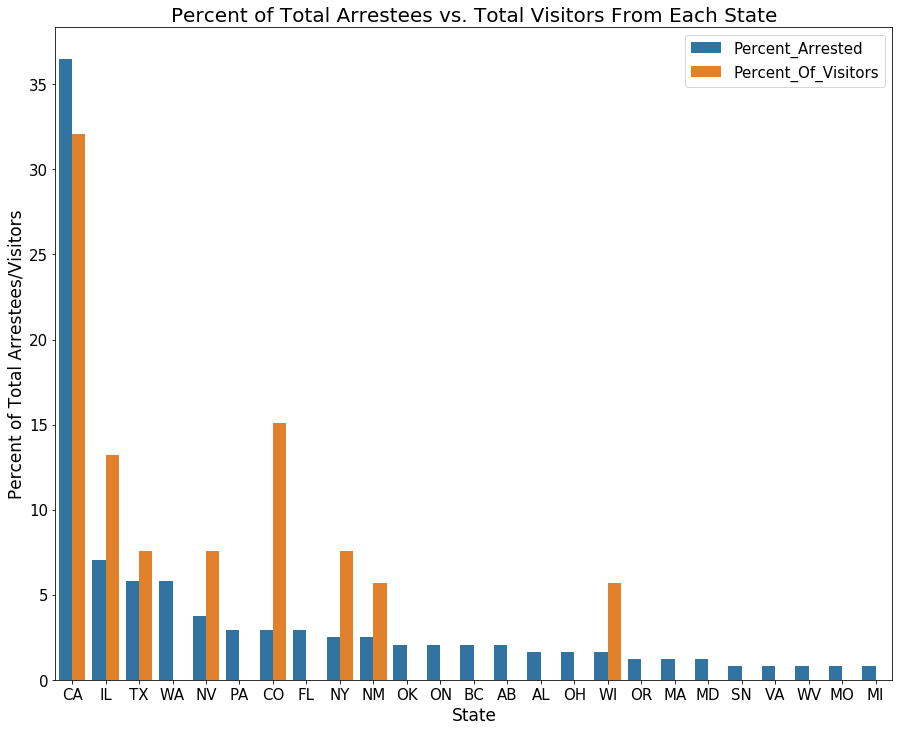

In [10]:
plt.rcParams["figure.figsize"] = [15, 12]

ax = sns.barplot(x=arrestees_and_visitors_long.iloc[:,0], \
                 y=arrestees_and_visitors_long.iloc[:,2], \
                 hue=arrestees_and_visitors_long.iloc[:,1], \
                 data=arrestees_and_visitors_long)

plt.title('Percent of Total Arrestees vs. Total Visitors From Each State',fontsize=20)
plt.ylabel('Percent of Total Arrestees/Visitors',fontsize=17)
plt.xlabel('State',fontsize=17)
plt.tick_params(labelsize=15)
plt.legend(loc='upper right',fontsize=15)